<a href="https://colab.research.google.com/github/nikhilbansal23/RottenTomatoesMoviesRatingPrediction/blob/main/rotten_tomatoes_movies_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import uuid
from datetime import datetime
from scipy.stats import norm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [301]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [302]:
movies = pd.read_csv('/content/drive/MyDrive/Datasets/Rotten Tomatoes/rotten_tomatoes_movies.csv')
critic_reviews = pd.read_csv('/content/drive/MyDrive/Datasets/Rotten Tomatoes/rotten_tomatoes_critic_reviews_50k.csv')

In [303]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [304]:
print("Movies data count "+str(len(movies)))
print("Reviews data count "+str(len(critic_reviews)))

Movies data count 17712
Reviews data count 50000


In [305]:
rt = pd.merge(movies, critic_reviews, on='rotten_tomatoes_link', suffixes=('_df1', '_df2'))


In [306]:
date_columns = [col for col in rt.columns if col.endswith('_date')]

# Convert selected columns to datetime
rt[date_columns] = rt[date_columns].apply(pd.to_datetime)

In [307]:
rt.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'critic_name', 'top_critic', 'publisher_name', 'review_type',
       'review_score', 'review_date', 'review_content'],
      dtype='object')

In [308]:
print("Rotten Tomatoes data count "+str(len(rt)))

Rotten Tomatoes data count 50000


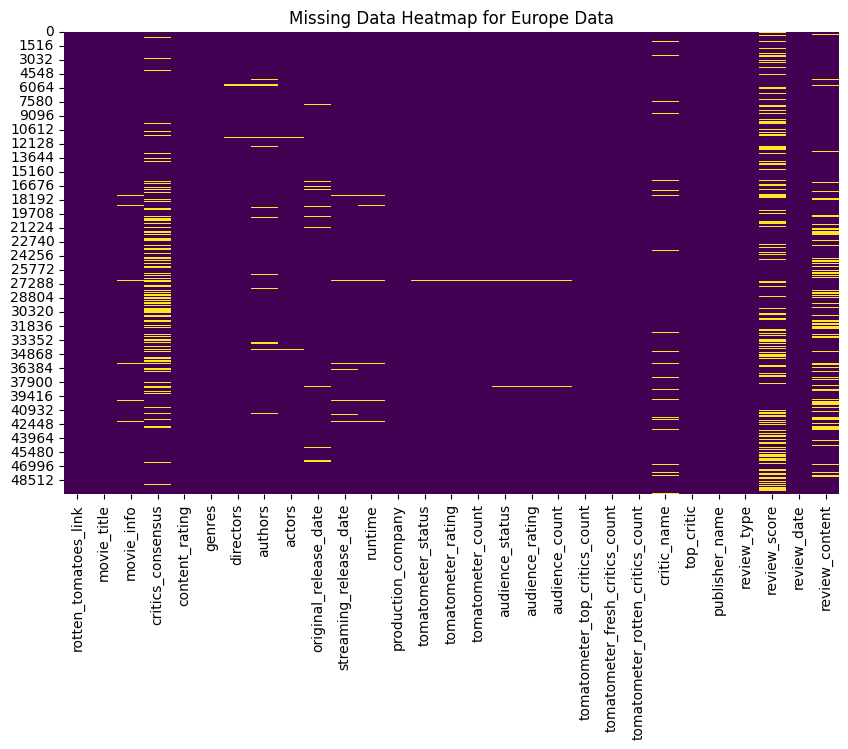

In [309]:
missing_data = rt.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(rt.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [310]:
#cool method to handle null values
def handle_nulls_by_dtype(dataframe, inplace=True):
    for col in dataframe.columns:
        dtype = dataframe[col].dtype
        if pd.api.types.is_numeric_dtype(dtype):
            # Fill null values in numeric columns (including int and float) with 0
            dataframe[col] = dataframe[col].fillna(0)
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            # Fill null values in datetime columns with a specific date (e.g., '2023-01-01')
            dataframe[col] = dataframe[col].fillna(pd.to_datetime('2023-01-01'))
        elif pd.api.types.is_string_dtype(dtype):
            # Fill null values in string columns with a specific value (e.g., 'Unknown')
            dataframe[col] = dataframe[col].fillna('Unknown')
        # Handling integer columns separately
        elif pd.api.types.is_integer_dtype(dtype):
            # Fill null values in integer columns with 0
            dataframe[col] = dataframe[col].fillna(0)

In [311]:
handle_nulls_by_dtype(rt)

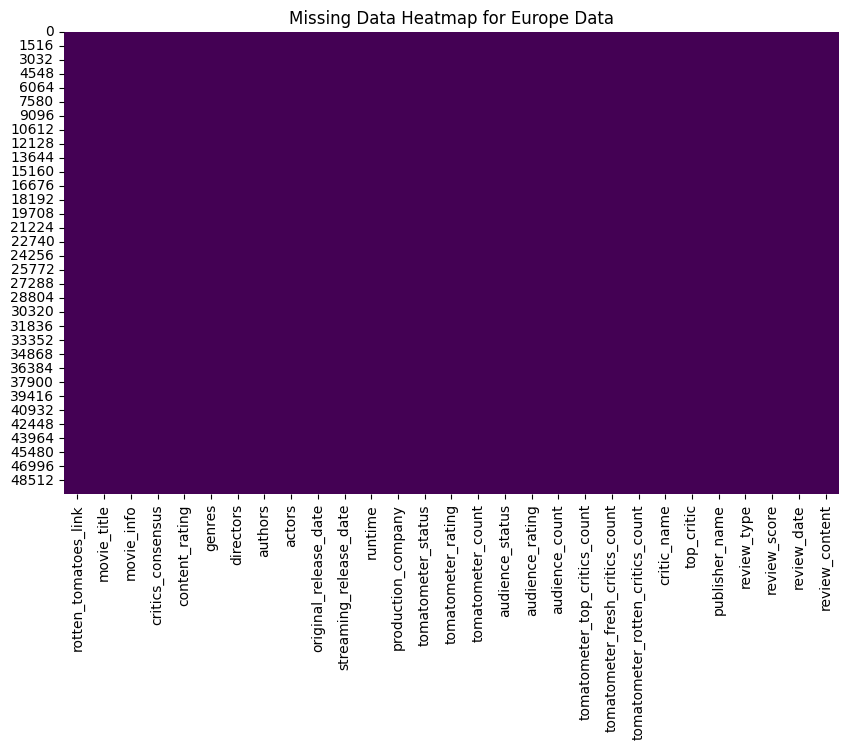

In [312]:
missing_data = rt.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(rt.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [313]:
rt.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,107.882440,61.535540,74.987760,63.584400,2.675137e+05,19.372520,44.600680,30.431100
std,23.239817,28.156468,58.884649,20.188914,2.192578e+06,15.022669,42.910912,33.953536
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,95.000000,39.000000,31.000000,48.000000,8.297000e+03,7.000000,15.000000,5.000000
50%,104.000000,67.000000,56.000000,66.000000,3.354900e+04,15.000000,33.000000,16.000000
75%,118.000000,88.000000,112.000000,80.000000,1.004900e+05,31.000000,57.000000,48.000000
max,254.000000,100.000000,309.000000,100.000000,3.340399e+07,58.000000,278.000000,151.000000


In [314]:
rt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rotten_tomatoes_link              50000 non-null  object        
 1   movie_title                       50000 non-null  object        
 2   movie_info                        50000 non-null  object        
 3   critics_consensus                 50000 non-null  object        
 4   content_rating                    50000 non-null  object        
 5   genres                            50000 non-null  object        
 6   directors                         50000 non-null  object        
 7   authors                           50000 non-null  object        
 8   actors                            50000 non-null  object        
 9   original_release_date             50000 non-null  datetime64[ns]
 10  streaming_release_date            50000 non-nu

In [315]:
# Group by 'host_id' and calculate total earnings for each host
review_type = rt.groupby('review_type')['rotten_tomatoes_link'].count().reset_index()
review_type = review_type.rename(columns={'rotten_tomatoes_link': 'count'})

sorted_earnings = review_type.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='review_type', y='count', title='Review Type',
             labels={'review_type': 'Reviews', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [316]:
rt['original_release_year'] = rt['original_release_date'].dt.year

In [317]:
# rt.groupby('review_score')['rotten_tomatoes_link'].count()
rt.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'critic_name', 'top_critic', 'publisher_name', 'review_type',
       'review_score', 'review_date', 'review_content',
       'original_release_year'],
      dtype='object')

In [318]:
# rt.head()

In [319]:
# Group by critic and count the number of reviews
df = rt[rt['critic_name'] != 'Unknown']

reviews_by_critic = df.groupby('critic_name').size().reset_index(name='num_reviews')

# Sort critics by the number of reviews and take the top 10
top_10_critics = reviews_by_critic.nlargest(10, 'num_reviews')

# Merge with the original dataframe to get the top_critic information in the hover
top_10_critics = pd.merge(top_10_critics, df.drop_duplicates('critic_name'), on='critic_name', how='left')

# Plotting with Plotly
fig = px.bar(top_10_critics, x='critic_name', y='num_reviews',
             color='top_critic', color_discrete_map={True: 'blue', False: 'orange'},
             hover_data={'top_critic': True},
             labels={'critic_name': 'Critic Name', 'num_reviews': 'Number of Reviews'},
             title='Top 10 Critics by Number of Reviews')

fig.update_layout(xaxis={'categoryorder': 'total descending'})

fig.show()

In [320]:
df = rt[rt['tomatometer_status'] != 'Unknown']
# Grouping by 'tomatometer_status' and summing the number of reviews
reviews_by_status = df.groupby('tomatometer_status')['rotten_tomatoes_link'].size().reset_index(name='num_reviews')

# Plotting a bar chart with Plotly
fig = px.bar(reviews_by_status, x='tomatometer_status', y='num_reviews',
             labels={'tomatometer_status': 'Tomatometer Status', 'num_reviews': 'Number of Reviews'},
             title='Number of Reviews by Tomatometer Status')

fig.show()

In [321]:

df = rt[rt['audience_status'] != 'Unknown']
# Grouping by 'tomatometer_status' and summing the number of reviews
reviews_by_status = df.groupby('audience_status')['rotten_tomatoes_link'].size().reset_index(name='num_reviews')

# Plotting a bar chart with Plotly
fig = px.bar(reviews_by_status, x='audience_status', y='num_reviews',
             labels={'audience_status': 'Audience Status', 'num_reviews': 'Number of Reviews'},
             title='Number of Reviews by Audience Status')

fig.show()

In [322]:
date_col = ['original_release_year','review_date','streaming_release_date','original_release_date']
rt.drop(date_col, axis=1, inplace = True)

In [323]:
# genres_dummies = rt['genres'].str.get_dummies(sep=', ')
# # Concatenating the one-hot encoded genres with the original DataFrame
# # df = pd.concat([df, genres_dummies], axis=1)
# genres_dummies
# # # Dropping the original 'genre' column
# # df.drop('genre', axis=1, inplace=True)


In [324]:
# Group by 'host_id' and calculate total earnings for each host
production_company = rt.groupby('production_company')['rotten_tomatoes_link'].count().reset_index()
production_company = production_company.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_companies = production_company.head(5)

sorted_earnings = top_10_companies.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='production_company', y='count', title='Production House',
             labels={'production_company': 'Production House', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


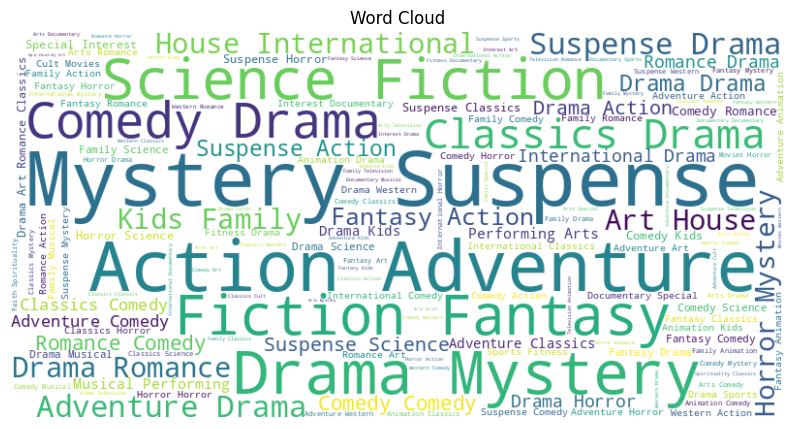

In [325]:
# Concatenate the values from the column into a single string
text = ' '.join(rt['genres'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [326]:
# Splitting the genres and creating a list of all genres
all_genres = [genre.split(', ') for genre in rt['genres']]
all_genres = [item for sublist in all_genres for item in sublist]

# Counting the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Extracting the most common genres (let's say top 2)
top_genres = genre_counts.head(10).index.tolist()
# Creating new columns for the top genres with binary indicators (0 and 1)
for genre in top_genres:
    rt[genre] = rt['genres'].str.contains(genre).astype(int)

# Dropping the original 'genre' column
rt.drop('genres', axis=1, inplace=True)



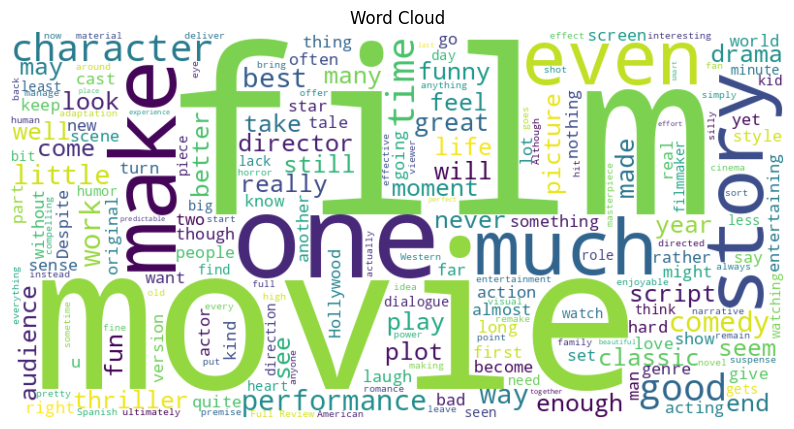

In [327]:
# Concatenate the values from the column into a single string
df = rt[rt['review_content'] != 'Unknown']
text = ' '.join(df['review_content'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


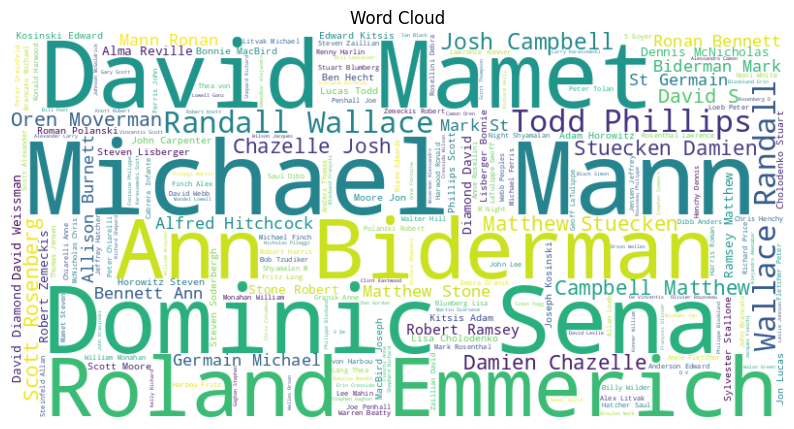

In [328]:
# Concatenate the values from the column into a single string
df = rt[rt['authors'] != 'Unknown']
text = ' '.join(df['authors'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [329]:
# Splitting the authors and creating a list of all author names
all_authors = [author.split(', ') for author in rt['authors']]
all_authors = [item for sublist in all_authors for item in sublist]

# Counting the occurrences of each author
author_counts = pd.Series(all_authors).value_counts()

# Extracting the most common authors (let's say top 2)
top_authors = author_counts.head(10).index.tolist()
# Creating new columns for the top authors with binary indicators (0 and 1)
for author in top_authors:
    rt[author] = rt['authors'].str.contains(author).astype(int)

# Dropping the original 'authors' column
rt.drop('authors', axis=1, inplace=True)

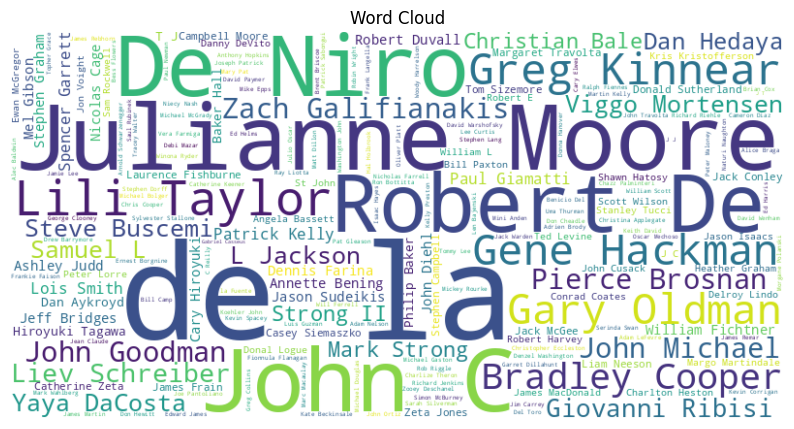

In [330]:
# Concatenate the values from the column into a single string
df = rt[rt['actors'] != 'Unknown']
text = ' '.join(df['actors'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [331]:
# Splitting the actors and creating a list of all actor names
all_actors = [actor.split(', ') for actor in rt['actors']]
all_actors = [item for sublist in all_actors for item in sublist]

# Counting the occurrences of each actor
actor_counts = pd.Series(all_actors).value_counts()

# Extracting the most common actors (let's say top 2)
top_actors = actor_counts.head(10).index.tolist()

# Creating new columns for the top actors with binary indicators (0 and 1)
for actor in top_actors:
    rt[actor] = rt['actors'].str.contains(actor).astype(int)

# Dropping the original 'actors' column
rt.drop('actors', axis=1, inplace=True)

In [332]:
# Function to get sentiment polarity using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    return 1 if polarity > 0 else 0

# Applying sentiment analysis to the 'review_content' column
rt['review_sentiment'] = rt['review_content'].apply(get_sentiment)
rt.drop('review_content', axis=1, inplace=True)

In [333]:
# Group by 'host_id' and calculate total earnings for each host
tomatometer_rating = rt.groupby('tomatometer_rating')['rotten_tomatoes_link'].count().reset_index()
tomatometer_rating = tomatometer_rating.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_companies = tomatometer_rating.head(5)

sorted_earnings = top_10_companies.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='tomatometer_rating', y='count', title='Tomatometer rating',
             labels={'tomatometer_rating': 'Tomatometer Rating', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [334]:
# Group by 'host_id' and calculate total earnings for each host
directors = rt.groupby('directors')['rotten_tomatoes_link'].count().reset_index()
directors = directors.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_directors = directors.head(10)

sorted_earnings = top_10_directors.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='directors', y='count', title='Top 10 Directors',
             labels={'directors': 'Directors', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [335]:
director_counts = rt['directors'].value_counts()

# Extracting the top 10 most common directors
top_10_directors = director_counts.head(10).index.tolist()

# Creating new columns for the top 10 directors with binary indicators (0 and 1) and adding a prefix
for director in top_10_directors:
    rt['director_' + director] = rt['directors'].apply(lambda x: 1 if x == director else 0)

# Dropping the original 'directors' column
rt.drop('directors', axis=1, inplace=True)


In [336]:
production_company_counts = rt['production_company'].value_counts()

# Extracting the top 10 most common directors
top_10_production_company_counts = production_company_counts.head(10).index.tolist()

# Creating new columns for the top 10 directors with binary indicators (0 and 1) and adding a prefix
for pc in top_10_production_company_counts:
    rt['ProductionHouse_' + director] = rt['production_company'].apply(lambda x: 1 if x == pc else 0)

# Dropping the original 'directors' column
rt.drop('production_company', axis=1, inplace=True)


In [337]:
rt.drop(['ProductionHouse_Unknown','director_Unknown','review_score'], axis=1, inplace=True)

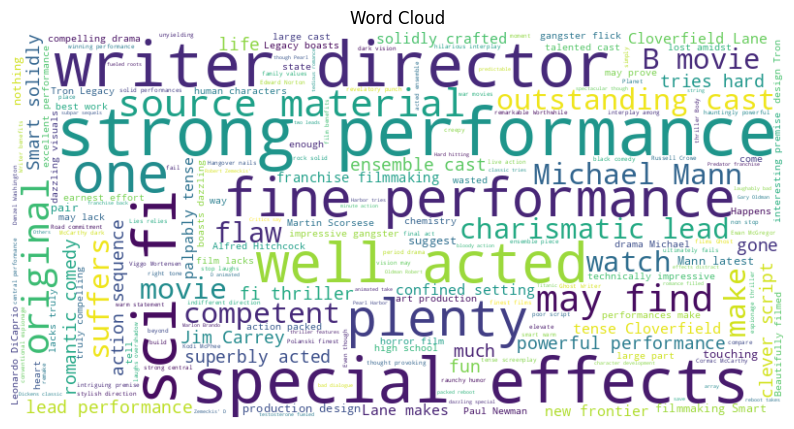

In [338]:
# Concatenate the values from the column into a single string
df = rt[rt['critics_consensus'] != 'Unknown']
text = ' '.join(df['critics_consensus'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [339]:
# Applying sentiment analysis to the 'review_content' column
rt['critics_consensus_sentiment'] = rt['critics_consensus'].apply(get_sentiment)
rt.drop('critics_consensus', axis=1, inplace=True)

In [340]:
# Group by 'host_id' and calculate total earnings for each host
publisher_name = rt.groupby('publisher_name')['rotten_tomatoes_link'].count().reset_index()
publisher_name = publisher_name.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_publisher_name = publisher_name.head(10)

sorted_earnings = top_10_publisher_name.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='publisher_name', y='count', title='Top 10 Publishers',
             labels={'publisher_name': 'Publishers', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [341]:
# Counting the occurrences of each publisher
publisher_counts = rt['publisher_name'].value_counts()

# Extracting the top 10 most common publishers
top_10_publishers = publisher_counts.head(3).index.tolist()

# Creating new columns for the top publishers and filling with binary indicators
for publisher in top_10_publishers:
    rt[f'publisher_{publisher}'] = (rt['publisher_name'] == publisher).astype(int)
rt.drop('publisher_name', axis=1, inplace=True)


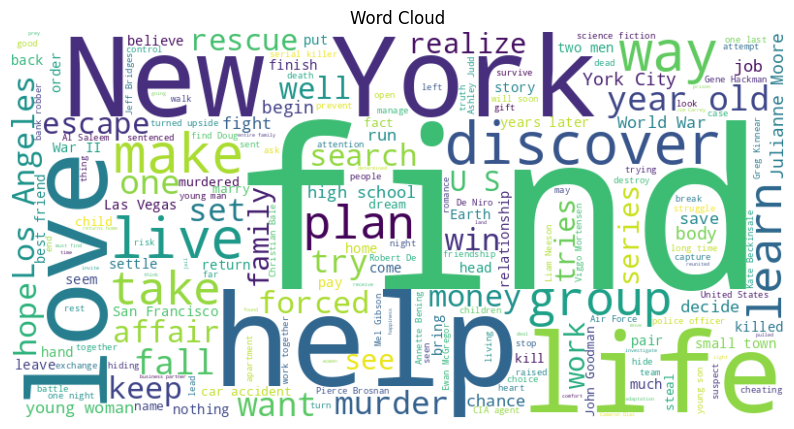

In [342]:
# Concatenate the values from the column into a single string
df = rt[rt['movie_info'] != 'Unknown']
text = ' '.join(df['movie_info'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))
rt.drop('movie_info', axis=1, inplace=True)

In [343]:
# Group by 'host_id' and calculate total earnings for each host
tomatometer_rating = rt.groupby('tomatometer_rating')['rotten_tomatoes_link'].count().reset_index()
tomatometer_rating = tomatometer_rating.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_tomatometer_rating = tomatometer_rating.head(5)

sorted_earnings = top_10_tomatometer_rating.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='tomatometer_rating', y='count', title='Top 5 Tomatometer Rating',
             labels={'tomatometer_rating': 'Top Tomatometer Rating', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [344]:
# Define the bins and labels for audience count categories
bins = [0, 1000, 10000, 100000, float('inf')]  # Define your own bin boundaries
labels = ['Low', 'Medium', 'High', 'Very High']

# Create a new column 'Audience Volume' with categorical labels based on audience count bins
rt['Audience_Volume'] = pd.cut(df['audience_count'], bins=bins, labels=labels)


In [345]:
# Define the bins and labels for audience ratings categories
rating_bins = [0, 25, 50, 75, 100]  # Define your own bin boundaries (0-25, 26-50, 51-75, 76-100)
rating_labels = ['Low', 'Moderate', 'Good', 'Excellent']  # Assign text labels to the categories

# Create a new column 'Audience_Rating_Category' with categorical labels based on rating bins
rt['Audience_Rating_Category'] = pd.cut(df['audience_rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)
rt.drop('audience_rating', axis=1, inplace=True)

In [346]:
# Categorize runtime into bins, setting >200 as 'Long'
rt['runtime_category'] = pd.cut(rt['runtime'], bins=[0, 90, 120, 200, float('inf')], labels=['Short', 'Medium', 'Long', 'Very Long'])


In [347]:
del_list = ['critic_name','movie_title','rotten_tomatoes_link','audience_count','tomatometer_count','tomatometer_top_critics_count','tomatometer_fresh_critics_count','tomatometer_rotten_critics_count','runtime']
rt.drop(del_list, axis=1, inplace=True)

In [348]:
# Define the bins and labels for audience ratings categories
rating_bins = [0, 25, 50, 75, 100]  # Define your own bin boundaries (0-25, 26-50, 51-75, 76-100)
rating_labels = ['Low', 'Moderate', 'Good', 'Excellent']  # Assign text labels to the categories

# Create a new column 'Audience_Rating_Category' with categorical labels based on rating bins
rt['Tomatometer_Rating_Category'] = pd.cut(df['tomatometer_rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)
rt.drop('tomatometer_rating', axis=1, inplace=True)


In [349]:
getdummies = ['audience_status' , 'top_critic', 'review_type' , 'content_rating','Audience_Rating_Category', 'Audience_Volume', 'Tomatometer_Rating_Category','runtime_category']
dummies = pd.get_dummies(rt[getdummies])
dummies = dummies.astype(int)


In [350]:
rt = pd.concat([rt, dummies], axis=1)
rt.drop(columns= getdummies, inplace=True)

In [352]:
rt['tomatometer_status'].value_counts()

Rotten             21474
Fresh              14695
Certified-Fresh    13788
Unknown               43
Name: tomatometer_status, dtype: int64

In [356]:
status_mapping = {
    'Certified-Fresh': 2,
    'Fresh': 1,
    'Rotten': 0
}

# Filter out rows with 'Unknown' values in 'tomatometer_status' column
mask = rt['tomatometer_status'] != 'Unknown'
df_filtered = rt[mask].copy()  # Create a copy to avoid SettingWithCopyWarning

# Map categorical values to integers using .loc[]
df_filtered.loc[mask, 'tomatometer_status'] = df_filtered.loc[mask, 'tomatometer_status'].map(status_mapping)

<ipython-input-356-04bbb15420d9>:12: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [360]:
def highly_correlated_columns(df, threshold=0.7):

    # Calculate correlation matrix
    corr_matrix = df.corr().abs()

    # Extract upper triangle of correlation matrix without diagonal
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find column pairs with correlation above the threshold
    highly_correlated = [(col1, col2) for col1 in upper_triangle.columns
                         for col2 in upper_triangle.columns
                         if upper_triangle[col1][col2] > threshold]

    return highly_correlated



In [363]:
correlated_columns = highly_correlated_columns(df_filtered, threshold=0.7)
print("Highly correlated columns:")
print(correlated_columns)

Highly correlated columns:
[('Matthew Stuecken', 'Josh Campbell'), ('director_Michael Mann', 'Michael Mann'), ('director_Dominic Sena', 'Dominic Sena'), ('director_Roland Emmerich', 'Roland Emmerich'), ('director_Todd Phillips', 'Todd Phillips'), ('director_Dan Trachtenberg', 'Josh Campbell'), ('director_Dan Trachtenberg', 'Matthew Stuecken'), ('audience_status_Upright', 'audience_status_Spilled'), ('review_type_Rotten', 'review_type_Fresh'), ('Audience_Rating_Category_Moderate', 'audience_status_Spilled'), ('Audience_Rating_Category_Moderate', 'audience_status_Upright'), ('Tomatometer_Rating_Category_Excellent', 'tomatometer_status')]


In [359]:
len(df_filtered.columns)

72

In [364]:
high_corr_cols = [

                  'Josh Campbell','Michael Mann','Dominic Sena','Roland Emmerich','Todd Phillips','Josh Campbell','Matthew Stuecken','audience_status_Spilled','tomatometer_status','audience_status_Upright','review_type_Fresh'
]

In [365]:
df_filtered.drop(df_filtered[high_corr_cols], axis=1, inplace = True)

In [368]:
correlated_columns = highly_correlated_columns(df_filtered, threshold=0.6)
print("Highly correlated columns:")
print(correlated_columns)

Highly correlated columns:
[('director_Michael Mann', 'Ann Biderman'), ('director_Michael Bay', 'Randall Wallace'), ('director_Dan Trachtenberg', 'Bradley Cooper'), ('director_Dan Trachtenberg', 'John Goodman'), ('runtime_category_Long', 'runtime_category_Medium')]
